In [1]:
library(Seurat)
library(stats)
library(MAST)

Attaching SeuratObject

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, r

In [ ]:
meta_Tasic = read.csv('../data/Real_Tasic2016/original_files/GSE71585_Clustering_Results.csv', row.name = 1)
meta_Tasic = meta_Tasic[order(rownames(meta_Tasic)),]
# layer = list()
# for (i in 1:dim(meta_Tasic)[[1]]) {
#     t = meta_Tasic[i, 'primary_type']
#     t = unlist(strsplit(t, ' '))[[1]]
# #     print(t)
#     if (t == 'L2') t = 'L2/3'
#     else if ((t == 'L5a') | (t == 'L5b')) t = 'L5'
#     layer = c(layer, t)
# #     break
# }
# print(unlist(unique(layer)))
# meta_Tasic['layer'] = layer

In [3]:
expr_Tasic = read.csv(
    '../../data/synthetic_metagene_free_cortex/500_cells_100_genes_low_variance_low_covariance_random_seed_0/files/expression_0.txt',
    row.name = 1, check.names = FALSE)
expr_Tasic = expr_Tasic[,order(colnames(expr_Tasic))]
print(dim(meta_Tasic))
print(dim(expr_Tasic))
print(identical(rownames(meta_Tasic), colnames(expr_Tasic)))

[1] 1809   12
[1] 24057  1809
[1] TRUE


Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


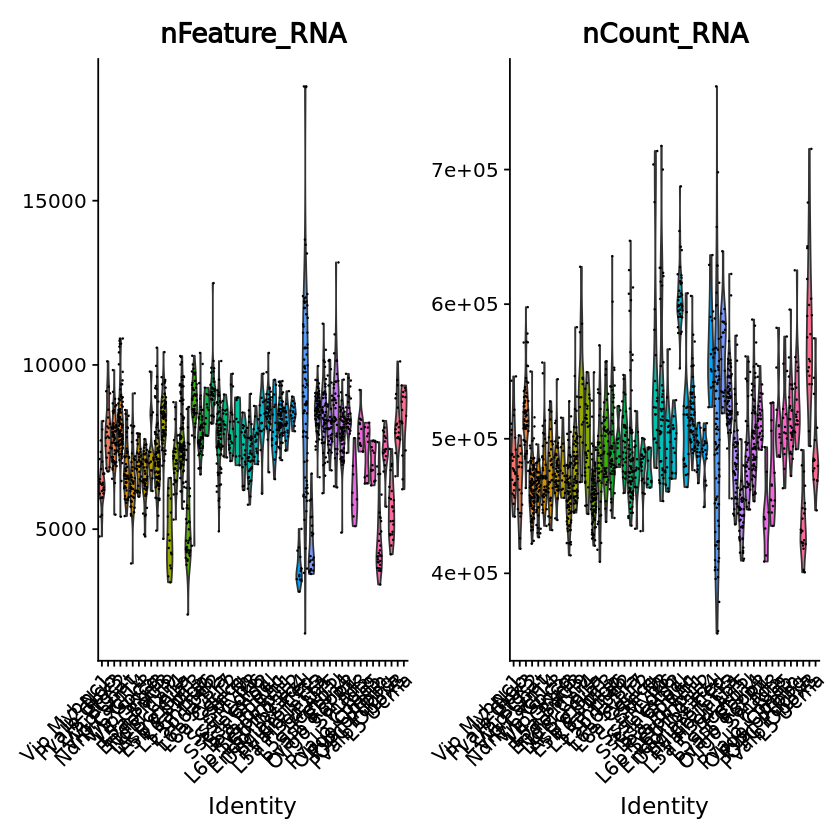

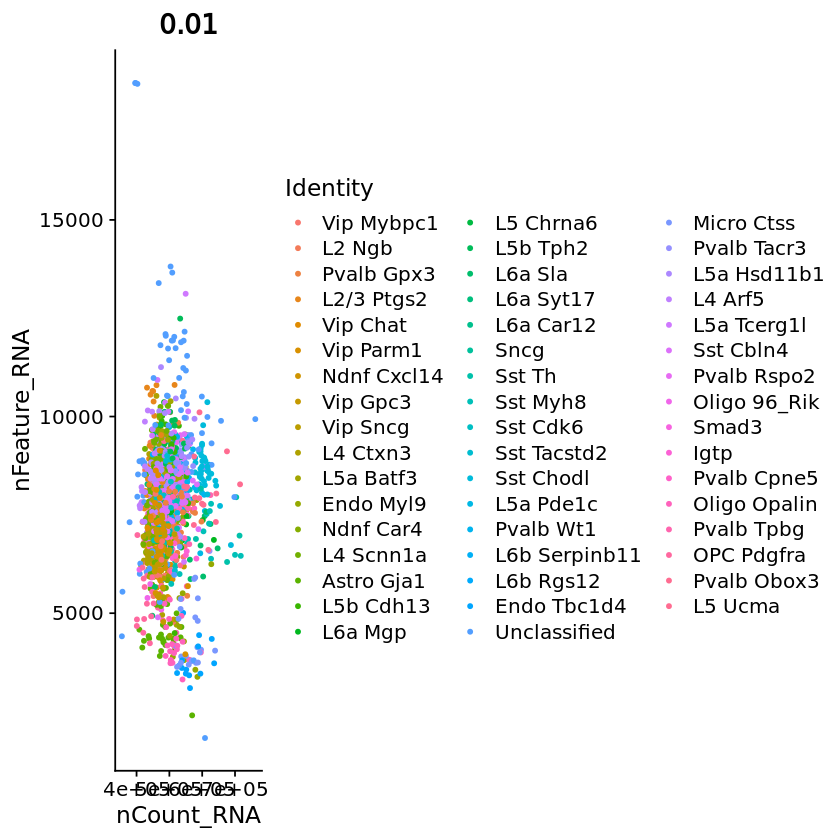

In [4]:
obj_Tasic = CreateSeuratObject(counts = expr_Tasic)
obj_Tasic@meta.data <- cbind(obj_Tasic@meta.data, meta_Tasic['primary_type'])
Idents(obj_Tasic) <- meta_Tasic['primary_type']
VlnPlot(obj_Tasic, features = c("nFeature_RNA", "nCount_RNA"), ncol = 2)
FeatureScatter(obj_Tasic, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")

In [5]:
obj_Tasic

An object of class Seurat 
24057 features across 1809 samples within 1 assay 
Active assay: RNA (24057 features, 0 variable features)

In [6]:
obj_Tasic <- NormalizeData(obj_Tasic, normalization.method = "LogNormalize", scale.factor = 10000)
# obj_Tasic <- FindVariableFeatures(obj_Tasic, selection.method = "vst", nfeatures = 5000)
# VariableFeaturePlot(obj_Tasic)
# all.genes <- rownames(obj_Tasic)
# obj_Tasic <- ScaleData(obj_Tasic, features = all.genes)
# obj_Tasic <- RunPCA(obj_Tasic, features = VariableFeatures(object = obj_Tasic))

In [7]:
meta_eng = read.csv(
    '../data/Real_SeqFISHPlus/results/clusters.csv',
    row.name = NULL, na.strings = "")
expr_eng = read.csv(
#     '../data/Real_SeqFISHPlus/original_files/sourcedata/cortex_svz_counts.csv',
    '../data/Real_SeqFISHPlus/results/expr.csv',
    row.name = NULL, check.names = FALSE)
print(dim(meta_eng))
print(dim(expr_eng))
rownames(expr_eng) = rownames(meta_eng)
print(identical(rownames(meta_eng), rownames(expr_eng)))

[1] 523   2
[1]   523 10000
[1] TRUE


Warning message:
“The following arguments are not used: row.names”


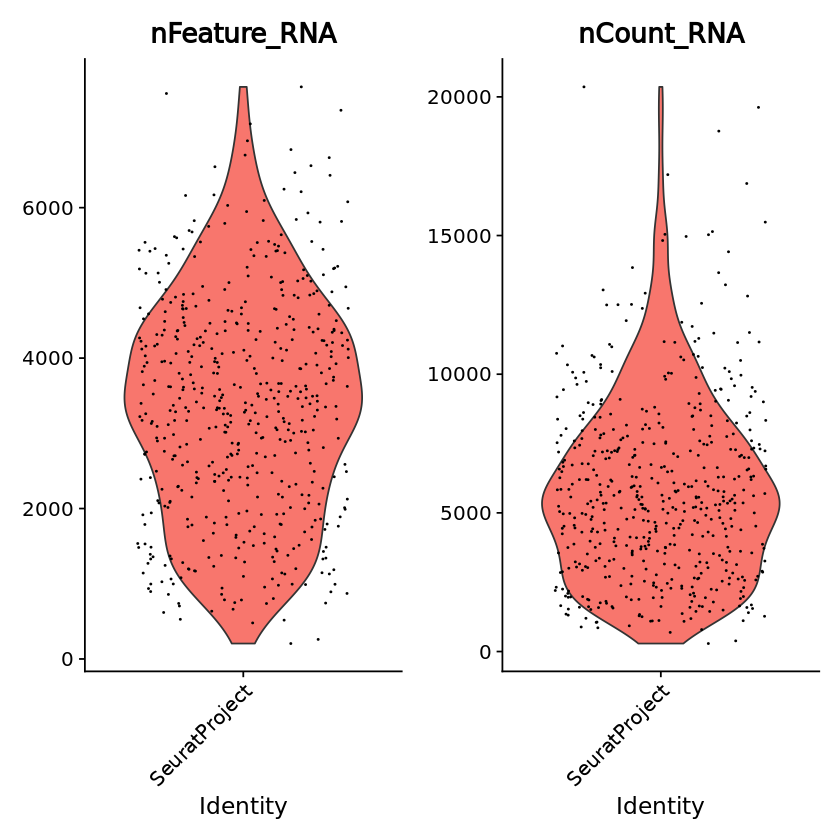

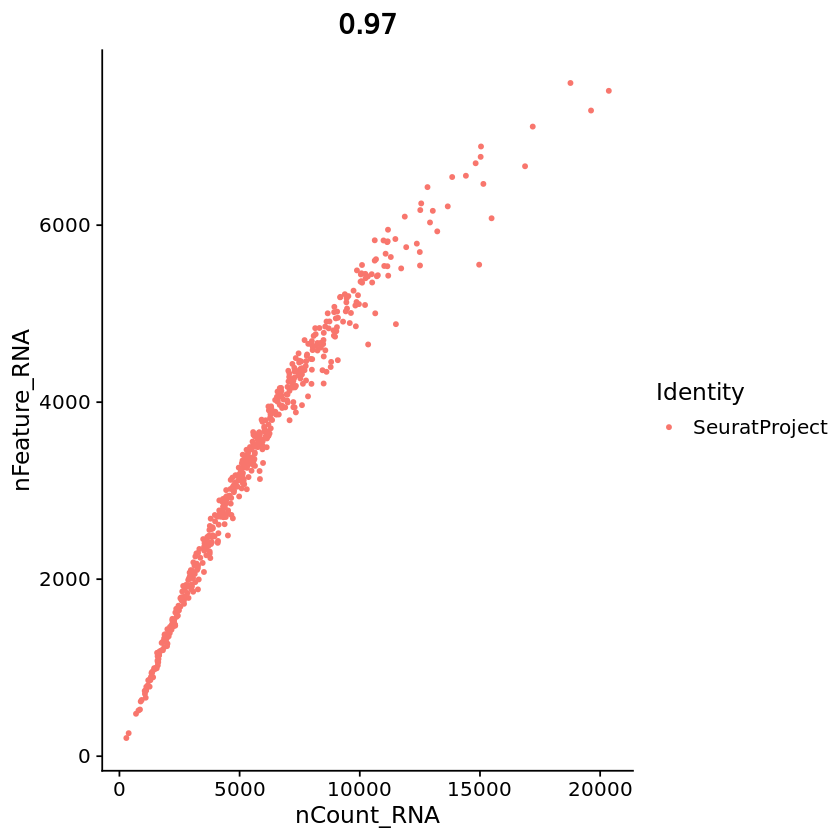

In [8]:
obj_eng = CreateSeuratObject(counts = t(expr_eng))
# obj_seqFISHplus@meta.data <- cbind(obj_seqFISHplus@meta.data, meta['primary_type'])
VlnPlot(obj_eng, features = c("nFeature_RNA", "nCount_RNA"), ncol = 2)
FeatureScatter(obj_eng, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
obj_eng <- NormalizeData(obj_eng, normalization.method = "LogNormalize", scale.factor = 10000)
# obj_eng <- FindVariableFeatures(obj_eng, selection.method = "vst", nfeatures = 5000)
# VariableFeaturePlot(obj_eng)
# all.genes <- rownames(obj_eng)
# obj_eng <- ScaleData(obj_eng, features = all.genes)
# obj_eng <- RunPCA(obj_eng, features = VariableFeatures(object = obj_eng))

In [9]:
obj_eng

An object of class Seurat 
10000 features across 523 samples within 1 assay 
Active assay: RNA (10000 features, 0 variable features)

In [10]:
common_genes_all = intersect(
    unique(rownames(GetAssayData(object = obj_Tasic, slot = "counts"))),
    unique(rownames(GetAssayData(object = obj_eng  , slot = "counts")))
)
stopifnot(length(common_genes_all) == 9541)

In [120]:
mytest1 <- function(
    obj, i, l, k, min.pct=0, logfc.threshold=-Inf, only.pos=TRUE, test.use='MAST', features=common_genes) {
#     obj1: seurat object
#     i1: list of label
#     l1: list of included labels
#     k1: list of labels in group 1
    message(k)
    ident = list()
    for (j in 1:length(i)) {
        if (! i[j] %in% l) t = 0
        else if (i[j] %in% k) t = 1
        else t = 2
        ident = c(ident, t)
    }
    stopifnot(identical(length(ident), dim(obj)[[2]]))
    Idents(obj) <- ident
    df = FindMarkers(
        obj, ident.1=1, ident.2=2, features=features,
        min.pct=min.pct,
        logfc.threshold=logfc.threshold,
        only.pos=only.pos,
        verbose=FALSE,
        test.use=test.use
    )
    message(paste(dim(df)[[1]], min(df['p_val_adj']), sum(df['p_val_adj'] < 1e-2), sep='\t'))
    return(df)
}

In [26]:
mytest2 <- function(df1, df2, pval.thr=1e-2) {
    df1 = data.frame(df1)
    df2 = data.frame(df2) 
#     n = dim(df1)[[1]]
    n = length(common_genes)
    g = intersect(unique(rownames(df1)), unique(rownames(df2)))
    message(paste('# of genes in df1 = ', dim(df1)[[1]], '# of genes in df2 = ', dim(df2)[[1]]))
    message(paste('# of common genes = ', length(g)))
#     n = length(g)
    df1 = df1[g,]
    df2 = df2[g,]
#     df1 = df1[order(df1$p_val),]
#     df2 = df2[order(df2$p_val),]
    df1['p_val_adj'] = p.adjust(p=df1[['p_val']], method='fdr', n=n)
    df2['p_val_adj'] = p.adjust(p=df2[['p_val']], method='fdr', n=n)
    message(paste(min(df1['p_val_adj']), sum(df1['p_val_adj'] < pval.thr), sep='\t'))
    message(paste(min(df2['p_val_adj']), sum(df2['p_val_adj'] < pval.thr), sep='\t'))
    
    message(paste('# in intersection = ', length(intersect(
        unique(rownames(df1)[df1['p_val_adj'] < pval.thr]),
        unique(rownames(df2)[df2['p_val_adj'] < pval.thr])
    ))))
    stopifnot(identical(rownames(df1[g,]), rownames(df2[g,])))
    
    idx1 = df1[g, 'p_val_adj'] < pval.thr
    idx2 = df2[g, 'p_val_adj'] < pval.thr
    cm = cbind(
        c(sum( idx1 & idx2), sum( idx1 & !idx2)),
        c(sum(!idx1 & idx2), n-sum(idx1 | idx2))
    )
    if (sum(idx1) > 0 && sum(idx2) > 0) {
        p = fisher.test(cm, alternative='greater')$p.value
        
#         message(fisher.test(table(
#             df1[g, 'p_val_adj'] < 1e-2,
#             df2[g, 'p_val_adj'] < 1e-2
#         ), alternative='greater')$p.value)
    }
    else { p = 1 }
    message(paste('p-value = ', p))
    return(list(cm, p))
}

# SpiceMix's major types

## overlap of DEGs

In [140]:
common_genes = common_genes_all
df = GetAssayData(obj_Tasic)
print(dim(df))
# df = df[common_genes, meta_Tasic['broad_type'] == 'Glutamatergic Neuron']
df = df[common_genes,as.vector(meta_Tasic['broad_type'] == 'Glutamatergic Neuron')]
print(dim(df))
df = df != 0
df = df[rowMeans(df) > .2,]
print(dim(df))
common_genes = rownames(df)
print(length(common_genes))

[1] 24057  1809
[1] 9541  812
[1] 5991  812
[1] 5991


In [141]:
layer = list()
for (i in 1:dim(meta_Tasic)[[1]]) {
    t = meta_Tasic[i, 'primary_type']
    t = unlist(strsplit(t, ' '))[[1]]
#     print(t)
    if (t == 'L2') t = 'L2/3'
    else if ((t == 'L5a') | (t == 'L5b')) t = 'L5'
    layer = c(layer, t)
#     break
}
print(unlist(unique(layer)))

label_list = c('L2/3', 'L4', 'L5', 'L6a', 'L6b')
df_Tasic = list(
    L23 = mytest1(obj_Tasic, layer, label_list, c('L2/3')),
    L4  = mytest1(obj_Tasic, layer, label_list, c('L4')  ),
    L5  = mytest1(obj_Tasic, layer, label_list, c('L5')  ),
    L6  = mytest1(obj_Tasic, layer, label_list, c('L6a', 'L6b'))
)
label_list = c('eL2/3', 'eL4', 'eL5', 'eL6a', 'eL6b')
df_eng = list(
    L23 = mytest1(obj_eng, meta_eng[['cluster']], label_list, c('eL2/3')),
    L4  = mytest1(obj_eng, meta_eng[['cluster']], label_list, c('eL4')),
    L5  = mytest1(obj_eng, meta_eng[['cluster']], label_list, c('eL5')),
    L6  = mytest1(obj_eng, meta_eng[['cluster']], label_list, c('eL6a', 'eL6b'))
)

 [1] "Vip"          "L2/3"         "Pvalb"        "Ndnf"         "L4"          
 [6] "L5"           "Endo"         "Astro"        "L6a"          "Sncg"        
[11] "Sst"          "L6b"          "Unclassified" "Micro"        "Oligo"       
[16] "Smad3"        "Igtp"         "OPC"         


L2/3


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!

3071	8.28388943556468e-122	206

L4


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!

4315	2.27433302515491e-116	567

L5


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!

1725	3.08787941041263e-74	301

L6aL6b


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!

1898	1.49393623027706e-70	160

eL2/3


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!

3031	4.26194869022119e-24	36

eL4


Done!

Combining coeffic

In [142]:
result_list = list()
for (i in 1:length(df_Tasic)) for (j in 1:length(df_eng)) {
    message(paste(names(df_Tasic)[[i]], names(df_eng)[[j]]))
    results = mytest2(
        df_Tasic[[i]], df_eng[[j]],
        pval.thr=.05
    )
    result_list = c(result_list, list(list(
        cluster1=names(df_Tasic)[[i]], cluster2=names(df_eng)[[j]],
        cm=results[[1]], pval=results[[2]])))
}

L23 L23

# of genes in df1 =  3071 # of genes in df2 =  3031

# of common genes =  1740

2.06296635525909e-122	330

2.55333346031152e-24	138

# in intersection =  56

p-value =  1.27499048609761e-35

L23 L4

# of genes in df1 =  3071 # of genes in df2 =  2822

# of common genes =  1448

1.30770172316387e-53	223

5.04032785466787e-15	45

# in intersection =  20

p-value =  1.55564265796702e-17

L23 L5

# of genes in df1 =  3071 # of genes in df2 =  2610

# of common genes =  1256

4.69489363045946e-81	191

6.90711617176778e-05	225

# in intersection =  23

p-value =  5.72644971977997e-07

L23 L6

# of genes in df1 =  3071 # of genes in df2 =  3048

# of common genes =  1443

9.2145324815997e-49	183

1.86917603266987e-09	30

# in intersection =  9

p-value =  1.56430419925168e-07

L4 L23

# of genes in df1 =  4315 # of genes in df2 =  3031

# of common genes =  2201

5.66385216515072e-117	1320

1.58335228805802e-17	136

# in intersection =  87

p-value =  2.38857401197748e-26

L4 L4

# o

In [143]:
for (r in result_list) if (r[['cluster1']] == r[['cluster2']]) {
    print(r[['pval']])
}

[1] 1.27499e-35
[1] 2.056206e-52
[1] 9.383882e-121
[1] 1.619059e-50


In [32]:
l = list()
for (r in result_list) {
    l = c(l, c(
            unname(r[c('cluster1', 'cluster2', 'pval')]),
            as.vector(r[['cm']]))
    )
}
write.table(l, '../data/Real_SeqFISHPlus/results/DEG_major_type.csv', sep=',', row.names=FALSE, col.names=FALSE)

## known marker genes

In [163]:
common_genes = common_genes_all
print(length(common_genes))

label_list = c('eL2/3', 'eL4', 'eL5', 'eL6a', 'eL6b')
df_eng = list(
    L23 = mytest1(obj_eng, meta_eng[['cluster']], label_list, c('eL2/3'), features=common_genes),
    L4  = mytest1(obj_eng, meta_eng[['cluster']], label_list, c('eL4')  , features=common_genes),
    L5  = mytest1(obj_eng, meta_eng[['cluster']], label_list, c('eL5')  , features=common_genes),
    L6  = mytest1(obj_eng, meta_eng[['cluster']], label_list, c('eL6a', 'eL6b'), features=common_genes),
    L6a = mytest1(obj_eng, meta_eng[['cluster']], label_list, c('eL6a'), features=common_genes),
    L6b = mytest1(obj_eng, meta_eng[['cluster']], label_list, c('eL6b'), features=common_genes)
)

[1] 9541


eL2/3


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!

5106	3.72862040566054e-24	40

eL4


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!

4414	1.78605642718799e-37	52

eL5


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!

3819	1.35492748181406e-11	17

eL6aeL6b


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!

4863	2.27235243877644e-37	62



In [171]:
df_eng[['L6a']] = mytest1(obj_eng, meta_eng[['cluster']], label_list, c('eL6a'), features=common_genes)

eL6a


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!

4595	2.35506740492428e-17	38



In [172]:
df_eng[['L6b']] = mytest1(obj_eng, meta_eng[['cluster']], label_list, c('eL6b'), features=common_genes)

eL6b


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!

4876	7.1945060778574e-10	22



In [164]:
df_eng[['L23']]['Enpp2',]

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Enpp2,2.784666e-06,0.7267159,0.686,0.472,0.02784666


In [166]:
df_eng[['L4']]['Rorb',]

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Rorb,0.004335136,0.4996561,0.402,0.294,1


In [195]:
df_eng[['L5']]['Sulf2',]

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Sulf2,0.001134638,0.5681622,0.741,0.534,1


In [180]:
df_eng[['L6a']]['Col6a1',]

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Col6a1,1.520712e-07,0.6878897,0.64,0.304,0.001520712


In [174]:
df_eng[['L6b']]['Ctgf',]

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Ctgf,1.223316e-08,1.803451,0.436,0.256,0.0001223316


# L6

In [196]:
common_genes = common_genes_all
df = GetAssayData(obj_Tasic)
print(dim(df))
# df = df[common_genes, meta_Tasic['broad_type'] == 'Glutamatergic Neuron']
df = df[common_genes,as.vector(meta_Tasic[['primary_type']] %in% c(
    'L6a Car12', 'L6a Mgp', 'L6a Sla', 'L6a Syt17', 'L6b Rgs12', 'L6b Serpinb11'))]
print(dim(df))
df = df != 0
df = df[rowMeans(df) > .2,]
print(dim(df))
common_genes = rownames(df)
print(length(common_genes))

[1] 24057  1809
[1] 9541  199
[1] 5815  199
[1] 5815


In [197]:
df = mytest1(obj_eng, meta_eng[['cluster']], c('eL6a', 'eL6b'), c('eL6b'), features=common_genes)

eL6b


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!

2944	1.42633250189691e-07	6



In [199]:
df['Ctgf',]

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Ctgf,5.571662e-05,1.890549,0.436,0.267,0.5571662


The marker of L6b, Ctgf, is significantly highly expressed in eL6b cells

In [200]:
m = meta_eng[['louvain']]
l = c('4', '5', '11')
f = common_genes
result_list = list(
    mytest1(obj_eng, m, l, c('4' ), features=f, only.pos=FALSE)['Ctgf', ],
    mytest1(obj_eng, m, l, c('5' ), features=f, only.pos=FALSE)['Ctgf', ],
    mytest1(obj_eng, m, l, c('11'), features=f, only.pos=FALSE)['Ctgf', ],
    mytest1(obj_eng, m, c('4', '5' ), c('4'), features=f, only.pos=FALSE)['Ctgf', ],
    mytest1(obj_eng, m, c('4', '11'), c('4'), features=f, only.pos=FALSE)['Ctgf', ],
    mytest1(obj_eng, m, c('5', '11'), c('5'), features=f, only.pos=FALSE)['Ctgf', ]
)

4


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!

5815	2.71466175730934e-06	99

5


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!

5815	0.699349215331575	0

11


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!

5815	0.000952530500175775	6

4


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!

5815	0.00130210449653925	5

4


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!

5815	0.000874073562025887	19

5


Done!

Combining coefficients and standard errors

C

In [203]:
result_list

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Ctgf,0.3312129,-0.9058555,0.264,0.367,1
,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Ctgf,0.7780108,-0.006034321,0.294,0.346,1
,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Ctgf,0.08631083,1.006151,0.5,0.279,1
,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


The marker Ctgf is not differentially expressed between any clusters

# L4

In [218]:
common_genes = common_genes_all
df = GetAssayData(obj_Tasic)
print(dim(df))
# df = df[common_genes, meta_Tasic['broad_type'] == 'Glutamatergic Neuron']
df = df[common_genes,as.vector(meta_Tasic[['primary_type']] %in% c('L4 Arf5', 'L4 Ctxn3', 'L4 Scnn1a'))]
print(dim(df))
df = df != 0
df = df[rowMeans(df) > .2,]
print(dim(df))
common_genes = rownames(df)
print(length(common_genes))

[1] 24057  1809
[1] 9541  222
[1] 5751  222
[1] 5751


In [219]:
label_list = c('L4 Arf5', 'L4 Ctxn3', 'L4 Scnn1a')
df_Tasic = list(
    Arf5   = mytest1(obj_Tasic, meta_Tasic[['primary_type']], label_list, c('L4 Arf5'  ), features=common_genes),
    Ctxn3  = mytest1(obj_Tasic, meta_Tasic[['primary_type']], label_list, c('L4 Ctxn3' ), features=common_genes),
    Scnn1a = mytest1(obj_Tasic, meta_Tasic[['primary_type']], label_list, c('L4 Scnn1a'), features=common_genes)
)

L4 Arf5


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!

3842	6.96284861477851e-13	32

L4 Ctxn3


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!

2159	0.000110855230271647	2

L4 Scnn1a


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!

2229	0.0389950434526988	0



In [221]:
label_list = c('6', '9', '19')
df_eng = list(
    L6  = mytest1(obj_eng, meta_eng[['louvain']], label_list, c('6') , only.pos=FALSE, features=common_genes),
    L9  = mytest1(obj_eng, meta_eng[['louvain']], label_list, c('9') , only.pos=FALSE, features=common_genes),
    L19 = mytest1(obj_eng, meta_eng[['louvain']], label_list, c('19'), only.pos=FALSE, features=common_genes),
    L6L9  = mytest1(obj_eng, meta_eng[['louvain']], c('6', '9' ), c('6'), only.pos=FALSE, features=common_genes),
    L6L19 = mytest1(obj_eng, meta_eng[['louvain']], c('6', '19'), c('6'), only.pos=FALSE, features=common_genes),
    L9L19 = mytest1(obj_eng, meta_eng[['louvain']], c('9', '19'), c('9'), only.pos=FALSE, features=common_genes)
)

6


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!

5751	0.238388099134524	0

9


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!

5751	0.568538578019981	0

19


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!

5751	2.62844853240749e-06	1

6


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!

5751	1	0

6


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!

5751	5.5086439071051e-07	3

9


Done!

Combining coefficients and standard errors

Calculating log-fold chan

In [222]:
for (i in 1:length(df_eng)) {
    print(paste(
        names(df_eng)[[i]],
        sum(p.adjust(df_eng[[i]][['p_val']], method='fdr') < 1e-2),
        min(p.adjust(df_eng[[i]][['p_val']], method='fdr'))
    ))
}

[1] "L6 0 0.038926397954502"
[1] "L9 0 0.326966536219291"
[1] "L19 5 1.51162075098755e-06"
[1] "L6L9 0 0.999823693245841"
[1] "L6L19 6 3.16802111097614e-07"
[1] "L9L19 1 0.00495308062387202"


No DEG between the two 'L4' clusters

In [223]:
df = mytest1(
    obj_eng, meta_eng[['louvain']], c('6', '9'), c('6'),
    features=c('Endou', 'Inhba', 'Lmo3', 'Rorb', 'Rspo1', 'Scnn1a', 'Tmem215', 'Whrn'), only.pos=FALSE)

6


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!

8	1	0



In [224]:
df

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Endou,0.2528615,-0.134048951,0.167,0.316,1
Scnn1a,0.2765893,0.376521318,0.271,0.132,1
Tmem215,0.7167747,-0.289774890,0.312,0.395,1
Whrn,0.7678465,0.183967735,0.271,0.316,1
Rspo1,0.7885299,0.221077024,0.250,0.289,1
Rorb,0.8273296,-0.142719023,0.312,0.263,1
Lmo3,0.9074605,0.001208189,0.375,0.421,1
Inhba,0.9546206,0.046953578,0.188,0.211,1


Known markers in Tasic et al. are not differentially expressed

In [237]:
for (i in 1:length(df_Tasic)) {
    df = df_Tasic[[i]]
    df = df[p.adjust(df[['p_val']], method='fdr') < 1e-2,]
    print(length(rownames(df)))
    df = mytest1(
        obj_eng, meta_eng[['louvain']], c('6', '9'), c('6'),
        features=rownames(df), only.pos=FALSE)
    df['p_val_adj'] = p.adjust(df[['p_val']], method='fdr')
    p = p.adjust(df[['p_val']], method='fdr')
    print(paste(dim(df)[[1]], min(p), sum(p<.05)))
}

[1] 362


6


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!

362	1	0



[1] "362 0.359284363410811 0"
[1] 3


6


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!

3	1	0



[1] "3 0.688345033505958 0"
[1] 3


6


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!

3	1	0



[1] "3 0.737093969970682 0"


# L5

In [204]:
common_genes = common_genes_all
df = GetAssayData(obj_Tasic)
print(dim(df))
# df = df[common_genes, meta_Tasic['broad_type'] == 'Glutamatergic Neuron']
df = df[common_genes,as.vector(meta_Tasic[['primary_type']] %in% c(
    'L5 Chrna6', 'L5 Ucma', 'L5a Batf3', 'L5a Hsd11b1', 'L5a Pde1c', 'L5a Tcerg1l', 'L5b Cdh13', 'L5b Tph2'))]
print(dim(df))
df = df != 0
df = df[rowMeans(df) > .2,]
print(dim(df))
common_genes = rownames(df)
print(length(common_genes))

[1] 24057  1809
[1] 9541  274
[1] 6163  274
[1] 6163


## known marker genes:
- Deptor for L5a
- Bcl6 for L5b
- Igta7 for L5 Ucma

In [210]:
df = mytest1(
    obj_Tasic, meta_Tasic[['primary_type']],
    c('L5a Hsd11b1', 'L5a Tcerg1l', 'L5a Pde1c', 'L5a Batf3', 'L5 Ucma', 'L5b Tph2', 'L5b Cdh13', 'L5 Chrna6'),
    c('L5a Batf3', 'L5a Hsd11b1', 'L5a Pde1c', 'L5a Tcerg1l'),
    only.pos=FALSE,
    features=c('Deptor', 'Bcl6', 'Itga7')
)

L5a Batf3L5a Hsd11b1L5a Pde1cL5a Tcerg1l


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!

3	1.97213066292534e-32	2



In [211]:
df

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Bcl6,8.197741e-37,-0.29280862,0.133,0.832,1.972131e-32
Deptor,2.475676e-30,0.83709699,0.884,0.267,5.955733e-26
Itga7,4.918763e-03,-0.01401531,0.012,0.089,1.000000e+00


In [213]:
df = mytest1(
    obj_Tasic, meta_Tasic[['primary_type']],
    c('L5a Hsd11b1', 'L5a Tcerg1l', 'L5a Pde1c', 'L5a Batf3', 'L5 Ucma', 'L5b Tph2', 'L5b Cdh13', 'L5 Chrna6'),
    c('L5 Ucma'),
    only.pos=FALSE,
    features=c('Bcl6', 'Deptor', 'Itga7')
)

L5 Ucma


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!

3	9.6705164853083e-05	1



In [214]:
df

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Itga7,4.019835e-09,0.08563444,0.5,0.012,9.670516e-05
Bcl6,8.399857e-05,-0.13008936,0.0,0.415,1.000000e+00
Deptor,1.899161e-01,-0.34417429,0.5,0.667,1.000000e+00


In [216]:
df = mytest1(
    obj_Tasic, meta_Tasic[['primary_type']],
    c('L5a Hsd11b1', 'L5a Tcerg1l', 'L5a Pde1c', 'L5a Batf3', 'L5 Ucma', 'L5b Tph2', 'L5b Cdh13', 'L5 Chrna6'),
    c('L5b Tph2', 'L5b Cdh13', 'L5 Chrna6'),
    only.pos=FALSE,
    features=c('Bcl6', 'Deptor', 'Itga7')
)

L5b Tph2L5b Cdh13L5 Chrna6


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!

3	6.9123586903815e-49	2



In [217]:
df

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Bcl6,2.873325e-53,0.34367327,0.988,0.122,6.912359e-49
Deptor,1.547437e-28,-0.84958477,0.224,0.852,3.722670e-24
Itga7,1.776698e-01,-0.00733385,0.012,0.053,1.000000e+00


In [138]:
label_list = c('19', '13', '18')
genes = c('Bcl6', 'Deptor', 'Itga7', 'Slc17a7')
df_eng = list(
    c19 = mytest1(obj_eng, meta_eng[['louvain']], label_list, c('19'), features=genes, only.pos=FALSE),
    c13 = mytest1(obj_eng, meta_eng[['louvain']], label_list, c('13'), features=genes, only.pos=FALSE),
    c18 = mytest1(obj_eng, meta_eng[['louvain']], label_list, c('18'), features=genes, only.pos=FALSE),
    c19c13 = mytest1(obj_eng, meta_eng[['louvain']], c('19', '13'), c('19'), features=genes, only.pos=FALSE),
    c19c18 = mytest1(obj_eng, meta_eng[['louvain']], c('19', '18'), c('19'), features=genes, only.pos=FALSE),
    c13c18 = mytest1(obj_eng, meta_eng[['louvain']], c('13', '18'), c('13'), features=genes, only.pos=FALSE)
)

19


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!

4	1	0

13


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!

4	1	0

18


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!

4	1	0

19


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!

4	1	0

19


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!

4	1	0

13


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!


In [139]:
for (i in 1:length(df_eng)) {
    print(names(df_eng)[[i]])
    print(df_eng[[i]])
}

[1] "c19"
             p_val  avg_log2FC pct.1 pct.2 p_val_adj
Deptor  0.07878478 -0.29650714 0.286 0.558         1
Itga7   0.08068826  0.16812740 0.333 0.423         1
Bcl6    0.12738049 -0.10844153 0.286 0.481         1
Slc17a7 0.98641938  0.02382472 1.000 1.000         1
[1] "c13"
            p_val  avg_log2FC pct.1 pct.2 p_val_adj
Bcl6    0.0834018 -0.49493038 0.333 0.478         1
Deptor  0.4832273  0.24653728 0.519 0.457         1
Itga7   0.6615680 -0.12650536 0.333 0.435         1
Slc17a7 0.9996467 -0.07687572 1.000 1.000         1
[1] "c18"
             p_val   avg_log2FC pct.1 pct.2 p_val_adj
Bcl6    0.02212910  0.554750722  0.64 0.312         1
Itga7   0.03251959 -0.027404689  0.52 0.333         1
Deptor  0.08314312 -0.002652099  0.60 0.417         1
Slc17a7 0.98306811  0.056895347  1.00 1.000         1
[1] "c19c13"
            p_val  avg_log2FC pct.1 pct.2 p_val_adj
Deptor  0.2621647 -0.36764307 0.286 0.519         1
Bcl6    0.4968533  0.25292817 0.286 0.333         1
Itga7 

## Known marker genes of finest cell types

not finished

In [81]:
label_list = c(
    'L5 Chrna6', 'L5 Ucma', 'L5a Batf3', 'L5a Hsd11b1', 'L5a Pde1c', 'L5a Tcerg1l', 'L5b Cdh13', 'L5b Tph2')
df_Tasic = list(
    L5aL5b = mytest1(
        obj_Tasic, meta_Tasic[['primary_type']],
        c('L5 Chrna6', 'L5a Batf3', 'L5a Hsd11b1', 'L5a Pde1c', 'L5a Tcerg1l', 'L5b Cdh13', 'L5b Tph2'),
        c('L5a Batf3', 'L5a Hsd11b1', 'L5a Pde1c', 'L5a Tcerg1l'),
        only.pos=TRUE,
        features=common_genes
    ),
    L5bL5a = mytest1(
        obj_Tasic, meta_Tasic[['primary_type']],
        c('L5 Chrna6', 'L5a Batf3', 'L5a Hsd11b1', 'L5a Pde1c', 'L5a Tcerg1l', 'L5b Cdh13', 'L5b Tph2'),
        c('L5 Chrna6', 'L5b Cdh13', 'L5b Tph2'),
        only.pos=TRUE,
        features=common_genes
    ),
    L5Ucma = mytest1(
        obj_Tasic, meta_Tasic[['primary_type']],
        c('L5 Chrna6', 'L5 Ucma', 'L5a Batf3', 'L5a Hsd11b1', 'L5a Pde1c',
          'L5a Tcerg1l', 'L5b Cdh13', 'L5b Tph2'),
        c('L5 Ucma'),
        only.pos=TRUE,
        features=common_genes
    )
)

L5a Batf3L5a Hsd11b1L5a Pde1cL5a Tcerg1l


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!

3444	5.56541601547236e-59	166

L5 Chrna6L5b Cdh13L5b Tph2


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!

2719	1.57275075159922e-51	197

L5 Ucma


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!

2654	1.23788291859464e-08	17

